# Moj rad

In [2]:
from __future__ import print_function
#import potrebnih biblioteka
import cv2
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD
from keras.models import model_from_json

#Sklearn biblioteka sa implementiranim K-means algoritmom
from sklearn import datasets
from sklearn.cluster import KMeans

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 12, 6 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

from pocetak import *
from services.preparation_for_neural_network import *
from services.show_result import *

Broj prepoznatih regiona: 30
Broj prepoznatih regiona: 30
duzina inputa: 60
duzina outputs: 60
Istrenirani model uspesno ucitan.


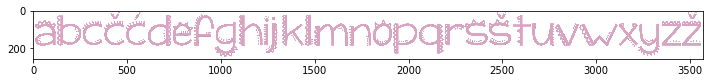

In [3]:
image_path0 = 'dataset/train/alphabet0.png'
letters0 = load_image_and_find_roi_train(image_path0)
alphabet0 = ['A', 'B', 'C', 'Č', 'Ć', 'D', 'E', 'F', 'G', 'H','I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S','Š', 'T', 'U','V', 'W', 'X', 'Y', 'Z', 'Ž']

image_path1 = 'dataset/train/alphabet1.png'
letters1 = load_image_and_find_roi_train(image_path1)
alphabet1 = ['a', 'b', 'c', 'č', 'ć', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
            'n', 'o', 'p', 'q',
            'r', 's', 'š', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ž']
alphabet= alphabet0 + alphabet1
letters = letters0 + letters1

inputs = prepare_for_ann(letters)
outputs = convert_output(alphabet)
print("duzina inputa: " + str(len(inputs)))
print("duzina outputs: " + str(len(outputs)))

# probaj da ucitas prethodno istreniran model
ann = load_trained_ann()

# ako je ann=None, znaci da model nije ucitan u prethodnoj metodi i da je potrebno istrenirati novu mrezu
if ann is None:
    print("Traniranje modela zapoceto.")
    ann = create_ann()
    ann = train_ann(ann, inputs, outputs)
    print("Treniranje modela zavrseno.")
    # serijalizuj novu mrezu nakon treniranja, da se ne trenira ponovo svaki put
    serialize_ann(ann)

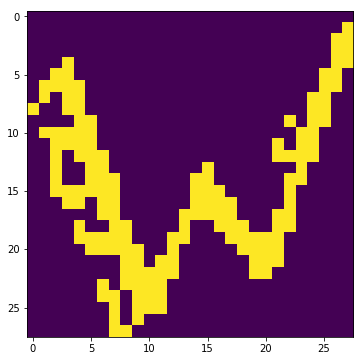

In [4]:
# Učitavanje slike i određivanje regiona od interesa
validation_image_path = 'dataset/validation/train2.png'
distances, letters = load_image_and_find_roi_validate(validation_image_path)

In [5]:
# PREDIKCIJA
print(extract_text_without_vocabulary(distances, letters, ann))

MY wiahes were Df čOnGumlnJ forče and iike the Heads Of the HYdra tHey muitipiled


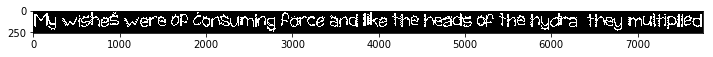

In [6]:
# POKUSAVAM POBOLJSATI SEGMENTACIJU
path = 'dataset/validation/train2.png'
img = cv2.imread(path)
image = img.copy()
best_channel = image[:, :, 1]
ret, image_bin = cv2.threshold(best_channel, 0, 255, cv2.THRESH_OTSU)
invertovana = invert(image_bin)
plt.imshow(invertovana,'gray')

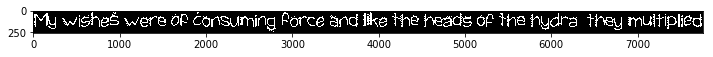

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
opening = cv2.morphologyEx(invertovana, cv2.MORPH_OPEN, kernel, iterations=1)
plt.imshow(opening,'gray')

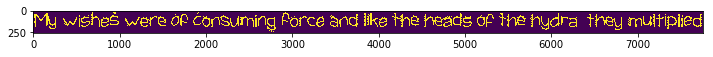

In [8]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)
plt.imshow(closing)

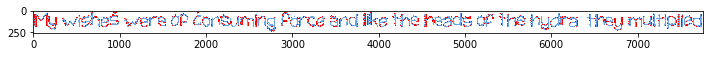

In [9]:
imga, contours, hierarchy = cv2.findContours(closing.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_crtanje = img.copy()
cv2.drawContours(image_crtanje, contours, -1, (255, 0, 0), 2)
plt.imshow(image_crtanje)

pronadjeno kontura: 98
pronadjeno koristnih kontura: 67


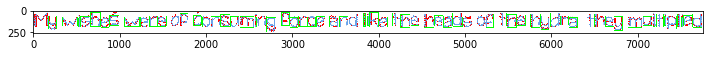

In [10]:
aproksimirane = []
regions_array = []
nekoristne = []
koristne_konture = []
korisni_regioni = []

print("pronadjeno kontura: " + str(len(contours)))
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    region = image_bin[y:y+h+1,x:x+w+1]
    if w < 10 or h < 10 or (h+w) < 100:
        nekoristne.append(1)
#         print("\t\t\th: " + str(h) + " w: " + str(w) + " size: " + str(h + w))
        continue
    cv2.rectangle(image_crtanje,(x,y),(x+w,y+h),(0,255,0),4)
#     print("h: " + str(h) + " w: " + str(w) + " size: " + str(h + w))
    regions_array.append([resize_region(region), (x,y,w,h)])
    koristne_konture.append(contour)
    korisni_regioni.append(resize_region(region))
    
# plt.imshow(korisni_regioni[2])


print("pronadjeno koristnih kontura: " + str(len(regions_array)))
# cv2.drawContours(image_crtanje, koristne_konture, -1, (0, 0, 0), 2)
plt.imshow(image_crtanje)

67
67
66


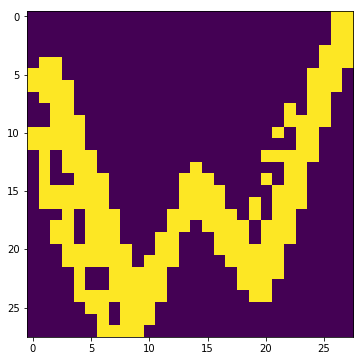

In [15]:
regions_array = sorted(regions_array, key=lambda item: item[1][0])
print(str(len(regions_array)))
# plt.imshow(regions_array[0][1])

sorted_regions = [invert(region[0]) for region in regions_array]
plt.imshow(sorted_regions[8])

sorted_rectangles = [region[1] for region in regions_array]
print(str(len(sorted_rectangles)))

region_distances = []
# Izdvojiti sortirane parametre opisujućih pravougaonika
# Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
for index in range(0, len(sorted_rectangles)-1):
    current = sorted_rectangles[index]
    next_rect = sorted_rectangles[index+1]
    distance = next_rect[0] - (current[0]+current[2]) #X_next - (X_current + W_current)
    region_distances.append(distance)
    
print(str(len(region_distances)))

In [ ]:
# selected_regions, letters, distances = img.copy(), sorted_regions, region_distances

In [13]:
# PREDIKCIJA
print(extract_text_without_vocabulary(region_distances, sorted_regions, ann))

My wišhes were of ćonGuminŠ forće anu iike the beadš of the bydro they muitiPiied
